In [16]:
import numpy as np

#from assets.keras.keras.datasets import shapes_3d
from assets.keras.keras.preprocessing.image import ImageDataGenerator
from assets.keras.keras.models import Sequential
from assets.keras.keras.layers.core import Dense, Dropout, Activation, Flatten
from assets.keras.keras.layers.convolutional import Convolution3D, MaxPooling3D, ZeroPadding3D
from assets.keras.keras.layers.normalization import BatchNormalization
from assets.keras.keras.optimizers import SGD, RMSprop, Adam
from assets.keras.keras.utils import np_utils, generic_utils
from assets.keras.keras.regularizers import l2
from assets.keras.keras.callbacks import EarlyStopping
import theano
import matplotlib.pyplot as plt
import math
from assets.vis_utils import *
%matplotlib inline
%load_ext autoreload
%autoreload 2

#load dataset from gen_dataset
import cPickle as pickle

In [3]:
from assets.gen_motion import gen_dataset
import math

angles = [0,math.pi/4,math.pi/2,math.pi*3/4,math.pi,math.pi*5/4,math.pi*3/2,math.pi*7/4]
#gen_dataset(size, N, obj_type, obj_theta, obj_vel, types, velocity, theta, coherence, dots, directions(opt))
X_train,Y_train,X_val,Y_val,X_test,Y_test = gen_dataset((16,32,32),10,None,['translate'],[1],angles,[1],[10],[0],dot_radius=1,contrast=1,Snoise=2,retina=0)

Y_train[:,2] = Y_train[:,2]/math.pi*4
Y_val[:,2] = Y_val[:,2]/math.pi*4
Y_test[:,2] = Y_test[:,2]/math.pi*4

##### WARNING ##########################################
# CHANGE THIS CODE IF YOU CHANGE THE NUMBER OF CLASSES #
######################################## WARNING #######
nb_classes = len(angles)
Y_train = np_utils.to_categorical(Y_train[:,2]-1, nb_classes)
Y_val = np_utils.to_categorical(Y_val[:,2]-1,nb_classes)
Y_test = np_utils.to_categorical(Y_test[:,2]-1, nb_classes)

TypeError: object of type 'int' has no len()

In [ ]:
print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print('X_val shape:', X_val.shape)
print('Y_val shape:', Y_val.shape)
print('X_test shape:', X_test.shape)
print('Y_test shape:', Y_test.shape)
print(X_train.shape[0], 'train samples')
print(X_val.shape[0], 'val samples')
print(X_test.shape[0], 'test samples')

In [ ]:
def build_eval(params,r,l,nb_f,nb_p,nb_c,data,model):
    batch_size, nb_classes, nb_epoch = params
    X_train,Y_train,X_val,Y_val,X_test,Y_test = data
    if model==None:
        model = Sequential()
        model.add(ZeroPadding3D((0,1,1),input_shape=(1,16,32,32), dim_ordering='th',))
        model.add(Convolution3D(nb_f[0],len_conv_dim1=1, len_conv_dim2=nb_c[0], len_conv_dim3=nb_c[0], border_mode='valid',
                                 activation='relu', W_regularizer=l2(r),name='LGN'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(1, nb_p[0], nb_p[0])))
        #model.add(Dropout(0.5))
        model.add(ZeroPadding3D((1,1,1)))
        model.add(Convolution3D(nb_f[1],len_conv_dim1=nb_c[1], len_conv_dim2=nb_c[1], len_conv_dim3=nb_c[1], border_mode='valid',
                                activation='relu', W_regularizer=l2(r), name='V1'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(nb_p[1], nb_p[1], nb_p[1])))
        #model.add(Dropout(0.5))
        #model.add(ZeroPadding3D((1,1,1)))
        model.add(Convolution3D(nb_f[2],len_conv_dim1=nb_c[2], len_conv_dim2=nb_c[2], len_conv_dim3=nb_c[2], border_mode='valid',
                                activation='relu', W_regularizer=l2(r), name='MT'))
        model.add(BatchNormalization())
        model.add(Flatten())
        #model.add(Dropout(0.5))
        #model.add(Dense(4, init='normal', activation='relu', W_regularizer=l2(reg)))
        model.add(Dense(nb_classes, init='normal', W_regularizer=l2(r)))
        model.add(Activation('softmax'))

        #Adam
        sgd = RMSprop(lr=l, decay=1e-6, momentum=0.9, nesterov=True)
        model.compile(loss='categorical_crossentropy', optimizer=sgd, class_mode='categorical')

        
    # control the model to crash early if nothing happens
    earlyStopping=EarlyStopping(monitor='val_loss', patience=20, verbose=0, mode='auto')

    hist = model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=nb_epoch, show_accuracy=True, verbose=1,
              validation_data=(X_val,Y_val), callbacks=[earlyStopping])
    scoretr = model.evaluate(X_train, Y_train, batch_size=batch_size, show_accuracy=True)
    scoreva = model.evaluate(X_val, Y_val, batch_size=batch_size, show_accuracy=True)
    return (model, hist, scoretr, scoreva)

In [ ]:
iters = 1

data = (X_train,Y_train,X_val,Y_val,X_test,Y_test)

best_model = None
best_val = 0
best_hist = None
best_scoretr = None
best_scoreva = None
best_params = None


batch_size = 20
nb_epoch = 20

params = (batch_size,nb_classes,nb_epoch)

for i in range(iters):
    # for each iteration
    print 'Training model #: ', i+1
    nb_filters = [4,4,4] #[2**np.random.randint(2,3),2**np.random.randint(2,3),2**np.random.randint(2,3)]
    nb_pool = [2,2]
    nb_conv = [3,3,3]
    reg = 1e-3#10**(-1*np.random.rand()*2)
    l_r = 1e-3#10**(-1*(np.random.rand()*2+4))
    model,hist,scoretr,scoreva = build_eval(params,reg,l_r,nb_filters,nb_pool,nb_conv,data,None)
    if scoreva[1] > best_val:
        best_model = model
        best_hist = hist
        best_scoretr = scoretr
        best_scoreva = scoreva
        best_val = scoreva[1]
        best_params = (reg,l_r,nb_filters,nb_pool,nb_conv)
    

In [1]:
#save model in motnet/assets/model folder
from assets.saveloadmodel import savemodel
from assets.saveloadmodel import loadmodel

#set model unique id and save model
#this saves two files one called "mymodel1.json" (net architecture)
#and another file "mymodelweights1.h5" (net weights)
#change modelid to update the saved filename (e.g., modelid = 2
#saves "mymodel2" and "mymodelweights2.h5")
modelid = 300
#savemodel(best_model,modelid)

#load saved model and evaluate for sanity check
best_model = loadmodel(modelid)


Using Theano backend.
/root/anaconda2/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")


Couldn't import dot_parser, loading of dot files will not be possible.


Using Theano backend.


In [ ]:
print thismodel
best_model = thismodel

In [ ]:
scorete = best_model.evaluate(X_test, Y_test, batch_size=20, show_accuracy=True)

print('Train loss:', best_scoretr[0])
print('Train accuracy:', best_scoretr[1])
print('Val loss:', best_scoreva[0])
print('Val accuracy:', best_scoreva[1])
print('Test loss:', scorete[0])
print('Test accuracy:', scorete[1])

print best_params

In [ ]:
#print best_model.history.history.keys()
plt.plot(np.asarray(best_model.history.history['loss'])[0:500])
plt.plot(np.asarray(best_model.history.history['val_loss'])[0:500])

In [ ]:
# (#outputs,#inputs,time,x-dir,y-dir)
for layer in model.layers:
    g = layer.get_config()
    h = layer.get_weights()
    #print g
    for hi in h:
        #print hi
        print hi.shape

In [4]:
from assets.vis_utils import *
from assets.regressions import *
from assets.gen_motion import gen_dataset
#Linear Regressions
#Speed, as an example
regression_types = ['speed','coherence','dots','contrast','Snoise']
regression_layers = ['LGN','V1s','V1c','MT']

train_scores = np.zeros((len(regression_types),len(regression_layers)))
cv_scores = np.zeros((len(regression_types),len(regression_layers)))
reg_models = [[0 for i in range(len(regression_layers))] for j in range(len(regression_types))]
Z_train_cache = [[0 for i in range(len(regression_layers))] for j in range(len(regression_types))]
Z_val_cache = [[0 for i in range(len(regression_layers))] for j in range (len(regression_types))]
Z_test_cache = [[0 for i in range(len(regression_layers))] for j in range (len(regression_types))]
y_train_cache = [[0 for i in range(len(regression_layers))] for j in range (len(regression_types))]
y_val_cache = [[0 for i in range(len(regression_layers))] for j in range (len(regression_types))]
y_test_cache = [[0 for i in range(len(regression_layers))] for j in range (len(regression_types))]

vary_params = {}
vary_params['speed'] = np.arange(0,5,0.5)
vary_params['coherence'] = np.arange(0,1,0.1)
vary_params['dots'] = np.arange(5,35,5)
vary_params['contrast'] = np.arange(0,1,0.1)
vary_params['Snoise'] = np.arange(0,100,10)

default_params = {}
default_params['speed'] = [3]
default_params['coherence'] = [1]
default_params['dots'] = [15]
default_params['contrast'] = [1]
default_params['Snoise'] = [4]

regression_style = {}
regression_style['speed'] = 'linear'
regression_style['coherence'] = 'linear'
regression_style['dots'] = 'linear'
regression_style['contrast'] = 'linear'
regression_style['Snoise'] = 'linear'

regression_index = {}
regression_index['speed'] = 1
regression_index['coherence'] = 3
regression_index['dots'] = 4
regression_index['contrast'] = 5
regression_index['Snoise'] = 6

for j in range(len(regression_types)):
    reg_type = regression_types[j]
    params = {}
    for label in regression_types:
        if(reg_type == label):
            params[label] = vary_params[label]
        else:
            params[label] = default_params[label]
    X_train,Y_train,X_val,Y_val,X_test,Y_test = gen_dataset((16,64,64),30,None,['translate'],params['speed'],angles,params['coherence'],params['dots'],[0],dot_radius=2,contrast=params['contrast'],Snoise=params['Snoise'],retina=0)

    for i in range(len(regression_layers)):
        regression_layer = regression_layers[i]
        Z_train, Z_val, Z_test = obtain_output(best_model,regression_layer,X_train,X_val,X_test)

        #[type,speed,angle,coherence,num dots,contrast,noise]
        reg_style = regression_style[reg_type]
        reg_index = regression_index[reg_type]
        frames_only = False
        average_spatial = True

        y_train = Y_train[:,reg_index]
        y_val = Y_test[:,reg_index]
        y_test = Y_test[:,reg_index]
        if(frames_only):
            Z_train = np.swapaxes(Z_train,1,2) #swap kernels and time
            Z_val = np.swapaxes(Z_val,1,2) #swap kernels and time
            Z_test = np.swapaxes(Z_test,1,2) #swap kernels and time
            if(average_spatial):
                Z_train = np.mean(Z_train,axis = (3,4))
                Z_val = np.mean(Z_val,axis = (3,4))
                Z_test = np.mean(Z_test,axis = (3,4))
                Z_train = np.reshape(Z_train,(Z_train.shape[0]*Z_train.shape[1],Z_train.shape[2]))
                Z_val = np.reshape(Z_val,(Z_val.shape[0]*Z_val.shape[1],Z_val.shape[2]))
                Z_test = np.reshape(Z_test,(Z_test.shape[0]*Z_test.shape[1],Z_test.shape[2]))
            else:
                Z_train = np.reshape(Z_train,(Z_train.shape[0]*Z_train.shape[1],Z_train.shape[2]*Z_train.shape[3]*Z_train.shape[4]))
                Z_val = np.reshape(Z_val,(Z_val.shape[0]*Z_val.shape[1],Z_val.shape[2]*Z_val.shape[3]*Z_val.shape[4]))
                Z_test = np.reshape(Z_test,(Z_test.shape[0]*Z_test.shape[1],Z_test.shape[2]*Z_test.shape[3]*Z_test.shape[4]))
            y_train = np.repeat(y_train,16)
            y_val = np.repeat(y_val,16)
            y_test = np.repeat(y_test,16)
        else:
            if(average_spatial):
                Z_train = np.mean(Z_train,axis = (2,3,4))
                Z_val = np.mean(Z_val,axis = (2,3,4))
                Z_test = np.mean(Z_test,axis = (2,3,4))
                Z_train = np.reshape(Z_train,(Z_train.shape[0],Z_train.shape[1]))
                Z_val = np.reshape(Z_val,(Z_val.shape[0],Z_val.shape[1]))
                Z_test = np.reshape(Z_test,(Z_test.shape[0],Z_test.shape[1]))
            else:
                Z_train = np.reshape(Z_train,(Z_train.shape[0],Z_train.shape[1]*Z_train.shape[2]*Z_train.shape[3]*Z_train.shape[4]))
                Z_val = np.reshape(Z_val,(Z_val.shape[0],Z_val.shape[1]*Z_val.shape[2]*Z_val.shape[3]*Z_val.shape[4]))
                Z_test = np.reshape(Z_test,(Z_test.shape[0],Z_test.shape[1]*Z_test.shape[2]*Z_test.shape[3]*Z_test.shape[4]))
        proportion_train = 1
        Z_train = Z_train[0:len(Z_train)*proportion_train]
        y_train = y_train[0:len(y_train)*proportion_train]

        if(reg_type == 'logistic'):
            min_val = np.min(y_train)
            max_val = np.max(y_train)
            y_train = (y_train - min_val)/max_val
            y_val = (y_val - min_val)/max_val

        best_model_reg,cv_score,train_score = regression(Z_train,Z_val,Z_test,y_train,y_val,y_test,model_type=reg_style)
        print regression_layer
        print cv_score
        print train_score
        train_scores[j,i] = train_score
        cv_scores[j,i] = cv_score
        reg_models[j][i] = best_model_reg
        Z_train_cache[j][i] = Z_train
        Z_val_cache[j][i] = Z_val
        Z_test_cache[j][i] = Z_test
        y_train_cache[j][i] = y_train
        y_val_cache[j][i] = y_val
        y_test_cache[j][i] = y_test

Running layer:  LGN
240/240 [==============================] - 7s     
LGN
0.0109071325938
0.0165106078255
Running layer:  V1s
240/240 [==============================] - 2s     
V1s
0.00344371330077
0.0049786503832
Running layer:  V1c
240/240 [==============================] - 2s     
V1c
0.512897715446
0.404479651806
Running layer:  MT
240/240 [==============================] - 3s     
MT
0.443253084112
0.436266593103
Running layer:  LGN
240/240 [==============================] - 1s     
LGN
0.00832257446155
0.00685579139344
Running layer:  V1s
240/240 [==============================] - 2s     
V1s
-0.0128871963665
0.00385693749858
Running layer:  V1c
240/240 [==============================] - 2s     
V1c
0.00649988785385
0.0107587500935
Running layer:  MT
240/240 [==============================] - 3s     
MT
0.0939403239573
0.0602858907123
Running layer:  LGN
144/144 [==============================] - 0s     

assets/keras/keras/models.py:677: UserWarning: Network returning invalid probability values.
  warnings.warn('Network returning invalid probability values.')
/root/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)



LGN
0.995491613547
0.993614393027
Running layer:  V1s
144/144 [==============================] - 1s     
V1s
0.981227483071
0.97785488469
Running layer:  V1c
144/144 [==============================] - 1s     
V1c
0.94249613304
0.916955294794
Running layer:  MT
144/144 [==============================] - 1s     
MT
0.664937973977
0.707649569601
Running layer:  LGN
240/240 [==============================] - 1s     
LGN
0.992836963886
0.993786340301
Running layer:  V1s
240/240 [==============================] - 2s     
V1s
0.972830620155
0.974290740948
Running layer:  V1c
240/240 [==============================] - 2s     
V1c
0.916609356265
0.923168328663
Running layer:  MT
240/240 [==============================] - 2s     
MT
0.826101596708
0.831253093413
Running layer:  LGN
240/240 [==============================] - 1s     
LGN
0.985133545214
0.984642276269
Running layer:  V1s
240/240 [==============================] - 2s     
V1s
0.98869993194
0.987614751619
Running layer:  V1c
240/240

In [8]:

#plt.plot(y_test_cache[0][0],reg_models[0][0].predict(Z_test_cache[0][0]),'o')
np.savetxt('cv_scores.txt',cv_scores)
np.savetxt('train_scores.txt',train_scores)
print train_scores

[[ 0.01651061  0.00497865  0.40447965  0.43626659]
 [ 0.00685579  0.00385694  0.01075875  0.06028589]
 [ 0.99361439  0.97785488  0.91695529  0.70764957]
 [ 0.99378634  0.97429074  0.92316833  0.83125309]
 [ 0.98464228  0.98761475  0.91397563  0.71375975]]


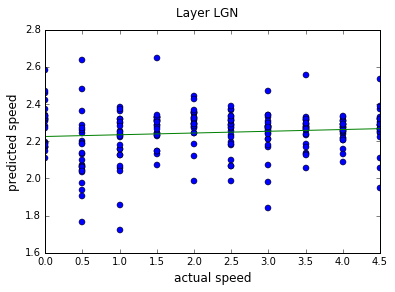

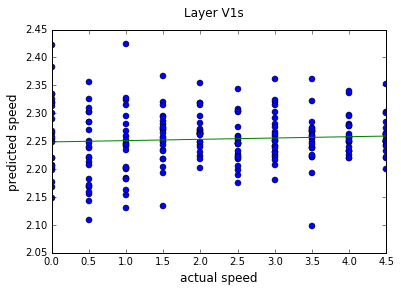

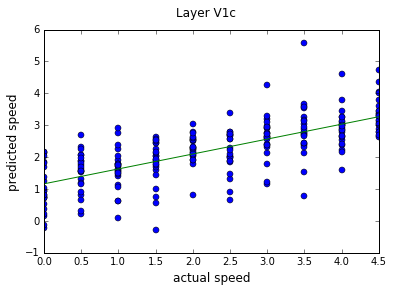

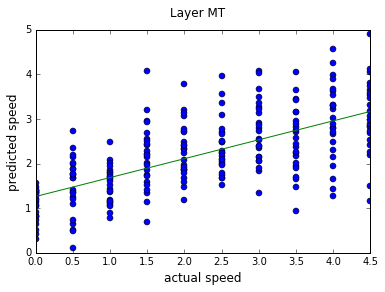

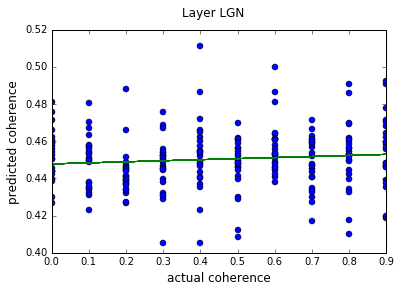

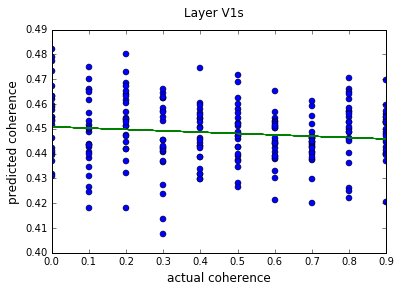

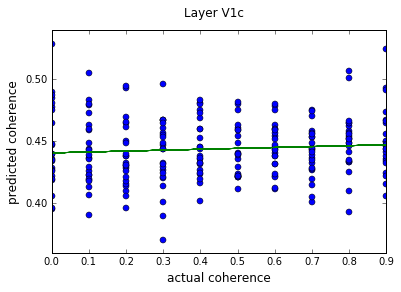

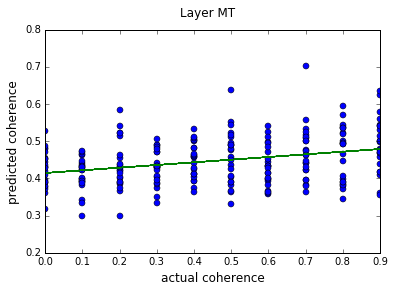

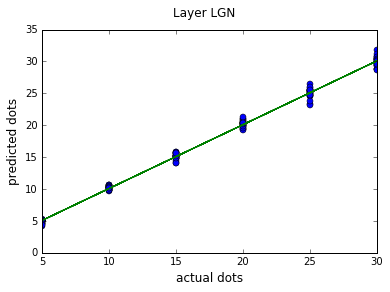

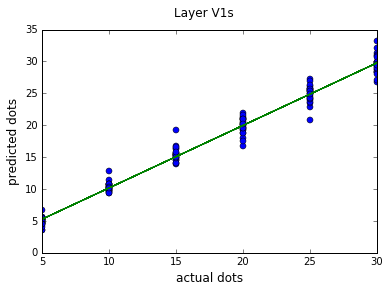

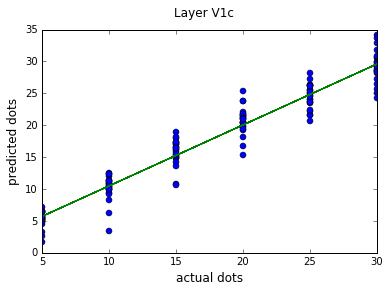

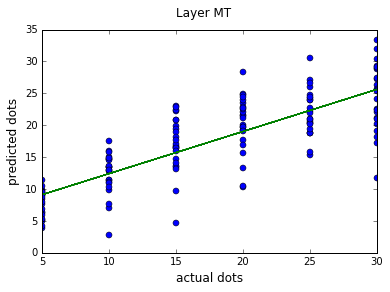

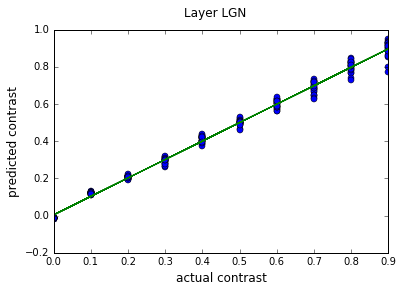

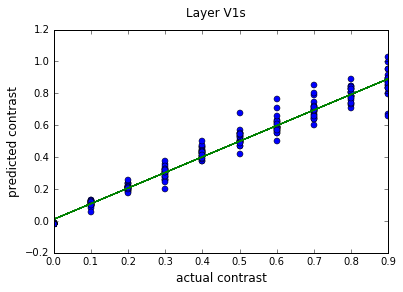

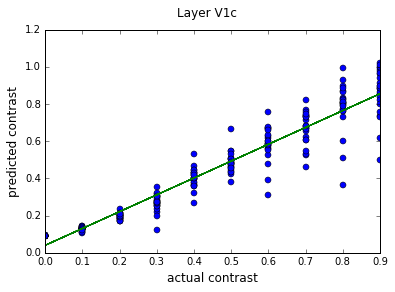

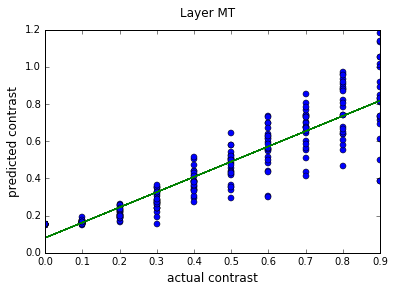

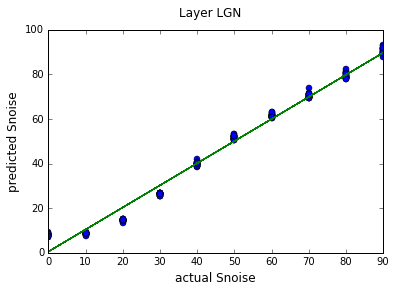

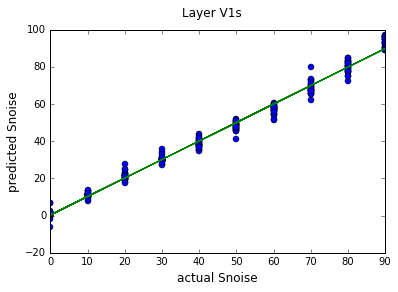

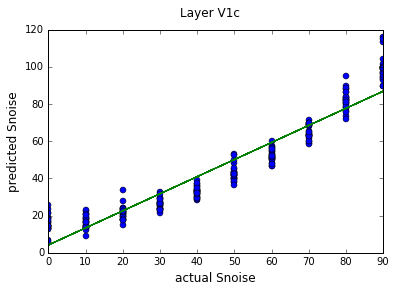

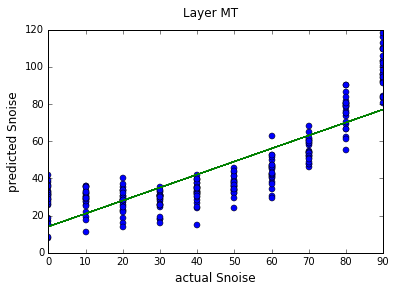

In [60]:
from sklearn import linear_model
fpath = "Data/RegressionPics/"
regression_types = ['speed','coherence','dots','contrast','Snoise']
regression_layers = ['LGN','V1s','V1c','MT']

for j in range(len(regression_types)):
    for i in range(len(regression_layers)):
        linemodel = linear_model.LinearRegression()
        fig = plt.figure()
        linemodel.fit(y_test_cache[j][i].reshape(-1,1), reg_models[j][i].predict(Z_test_cache[j][i]).reshape(-1,1))
        plt.plot(y_test_cache[j][i],reg_models[j][i].predict(Z_test_cache[j][i]),'o')
        plt.plot(y_test_cache[j][i],linemodel.predict(y_test_cache[j][i].reshape(-1,1)))
        fig.suptitle('Layer ' + regression_layers[i], fontsize=12)
        plt.xlabel('actual ' + regression_types[j], fontsize=12)
        plt.ylabel('predicted ' + regression_types[j], fontsize=12)
        fig.savefig(fpath+'regfig' +regression_types[j]+regression_layers[i]+ '.pdf', bbox_inches='tight')

In [ ]:
if(reg_type == 'logistic'):
    min_val = np.min(y_train)
    max_val = np.max(y_train)
    y_train = (y_train - min_val)/max_val
    y_val = (y_val - min_val)/max_val

best_model_reg,cv_score,best_score = regression(Z_train,Z_val,Z_test,y_train,y_val,y_test,model_type=reg_type)
print cv_score
print best_score

In [43]:
print len(np.arange(0.2,1.04,0.04))
print len(np.arange(0.6,.80,0.01))

21
21


In [ ]:
from assets.vis_utils import *
from assets.regressions import *
from assets.gen_motion import gen_dataset
#Linear Regressions
#Speed, as an example
regression_types = ['coherence','contrast']
all_types = ['speed','coherence','dots','contrast','Snoise']
regression_layers = ['LGN','V1s','V1c','MT']

afc_range = {}
afc_range['coherence'] = [np.arange(0.24,1.04,0.04)]
afc_range['contrast'] = np.arange(0.61,.80,0.01)
np.arange(0,5,0.5)

train_scores = np.zeros((len(afc_range['contrast']),len(regression_types),len(regression_layers)))
cv_scores = np.zeros((len(afc_range['contrast']),len(regression_types),len(regression_layers)))


vary_params = {}
vary_params['speed'] = np.arange(0,5,0.5)
vary_params['coherence'] = np.arange(0,1,0.1)
vary_params['dots'] = np.arange(5,35,5)
vary_params['contrast'] = np.arange(0,1,0.1)
vary_params['Snoise'] = np.arange(0,100,10)

default_params = {}
default_params['speed'] = [3]
default_params['coherence'] = [.2]
default_params['dots'] = [25]
default_params['contrast'] = [0.6]
default_params['Snoise'] = [4]

regression_style = {}
regression_style['speed'] = 'logistic'
regression_style['coherence'] = 'logistic'
regression_style['dots'] = 'logistic'
regression_style['contrast'] = 'logistic'
regression_style['Snoise'] = 'logistic'

regression_index = {}
regression_index['speed'] = 1
regression_index['coherence'] = 3
regression_index['dots'] = 4
regression_index['contrast'] = 5
regression_index['Snoise'] = 6

for j in range(len(regression_types)):
    reg_type = regression_types[j]
    for k in range(len(afc_range[reg_type])):
        second_val = afc_range[reg_type][k]
        params = {}
        for label in all_types:
            if(reg_type == label):
                params[label] = [default_params[label][0],second_val]
            else:
                params[label] = default_params[label]
        X_train,Y_train,X_val,Y_val,X_test,Y_test = gen_dataset((16,64,64),100,None,['translate'],params['speed'],angles,params['coherence'],params['dots'],[0],dot_radius=2,contrast=params['contrast'],Snoise=params['Snoise'],retina=0)

        for i in range(len(regression_layers)):
            regression_layer = regression_layers[i]
            Z_train, Z_val, Z_test = obtain_output(best_model,regression_layer,X_train,X_val,X_test)

            #[type,speed,angle,coherence,num dots,contrast,noise]
            reg_style = regression_style[reg_type]
            reg_index = regression_index[reg_type]
            frames_only = False
            average_spatial = True

            y_train = Y_train[:,reg_index]
            y_val = Y_test[:,reg_index]
            y_test = Y_test[:,reg_index]
            if(frames_only):
                Z_train = np.swapaxes(Z_train,1,2) #swap kernels and time
                Z_val = np.swapaxes(Z_val,1,2) #swap kernels and time
                Z_test = np.swapaxes(Z_test,1,2) #swap kernels and time
                if(average_spatial):
                    Z_train = np.mean(Z_train,axis = (3,4))
                    Z_val = np.mean(Z_val,axis = (3,4))
                    Z_test = np.mean(Z_test,axis = (3,4))
                    Z_train = np.reshape(Z_train,(Z_train.shape[0]*Z_train.shape[1],Z_train.shape[2]))
                    Z_val = np.reshape(Z_val,(Z_val.shape[0]*Z_val.shape[1],Z_val.shape[2]))
                    Z_test = np.reshape(Z_test,(Z_test.shape[0]*Z_test.shape[1],Z_test.shape[2]))
                else:
                    Z_train = np.reshape(Z_train,(Z_train.shape[0]*Z_train.shape[1],Z_train.shape[2]*Z_train.shape[3]*Z_train.shape[4]))
                    Z_val = np.reshape(Z_val,(Z_val.shape[0]*Z_val.shape[1],Z_val.shape[2]*Z_val.shape[3]*Z_val.shape[4]))
                    Z_test = np.reshape(Z_test,(Z_test.shape[0]*Z_test.shape[1],Z_test.shape[2]*Z_test.shape[3]*Z_test.shape[4]))
                y_train = np.repeat(y_train,16)
                y_val = np.repeat(y_val,16)
                y_test = np.repeat(y_test,16)
            else:
                if(average_spatial):
                    Z_train = np.mean(Z_train,axis = (3,4))
                    Z_val = np.mean(Z_val,axis = (3,4))
                    Z_test = np.mean(Z_test,axis = (3,4))
                    Z_train = np.reshape(Z_train,(Z_train.shape[0],Z_train.shape[1]*Z_train.shape[2]))
                    Z_val = np.reshape(Z_val,(Z_val.shape[0],Z_val.shape[1]*Z_val.shape[2]))
                    Z_test = np.reshape(Z_test,(Z_test.shape[0],Z_test.shape[1]*Z_test.shape[2]))
                else:
                    Z_train = np.reshape(Z_train,(Z_train.shape[0],Z_train.shape[1]*Z_train.shape[2]*Z_train.shape[3]*Z_train.shape[4]))
                    Z_val = np.reshape(Z_val,(Z_val.shape[0],Z_val.shape[1]*Z_val.shape[2]*Z_val.shape[3]*Z_val.shape[4]))
                    Z_test = np.reshape(Z_test,(Z_test.shape[0],Z_test.shape[1]*Z_test.shape[2]*Z_test.shape[3]*Z_test.shape[4]))
            proportion_train = 1
            Z_train = Z_train[0:len(Z_train)*proportion_train]
            y_train = y_train[0:len(y_train)*proportion_train]

            if(reg_style == 'logistic'):
                min_val = np.min(y_train)
                max_val = np.max(y_train)
                y_train = (y_train - min_val)/(max_val - min_val)
                y_val = (y_val - min_val)/(max_val - min_val)
                y_test = (y_test - min_val)/(max_val - min_val)
            best_model_reg,cv_score,train_score = regression(Z_train,Z_val,Z_test,y_train,y_val,y_test,model_type=reg_style)
            print regression_layer
            print cv_score
            print train_score
            train_scores[k,j,i] = train_score
            cv_scores[k,j,i] = cv_score

In [ ]:
visualize_grid(np.expand_dims(out[2],axis=1),ubound=255)

In [ ]:
W,b = best_model.layers[8].get_weights()
visualize_grid(W)

In [ ]:
best_model.layers[1].name

In [52]:
if(reg_style == 'logistic'):
    min_val = np.min(y_train)
    max_val = np.max(y_train)
    y_train = (y_train - min_val)/max_val
    y_val = (y_val - min_val)/max_val
    y_test = (y_test - min_val)/max_val

In [53]:
print y_train

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


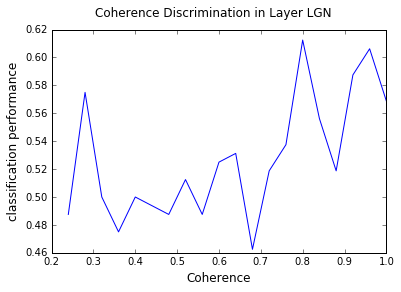

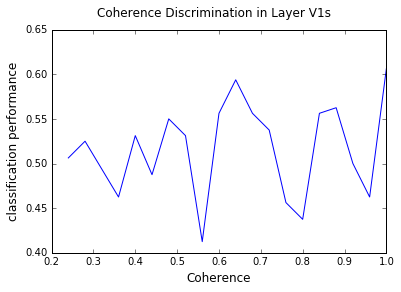

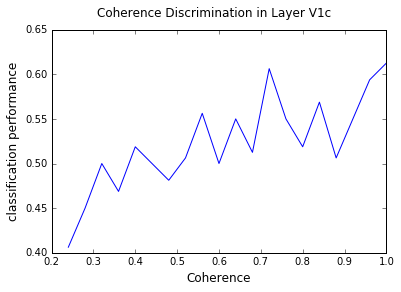

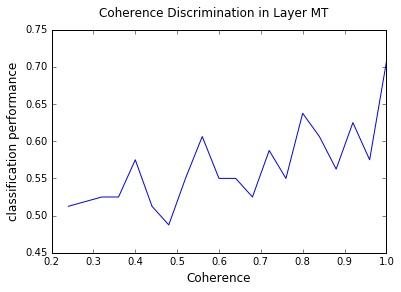

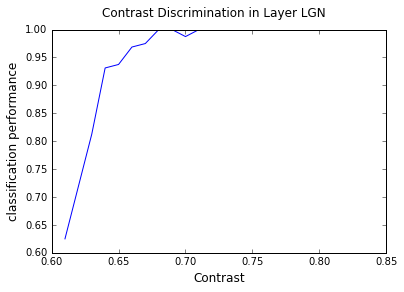

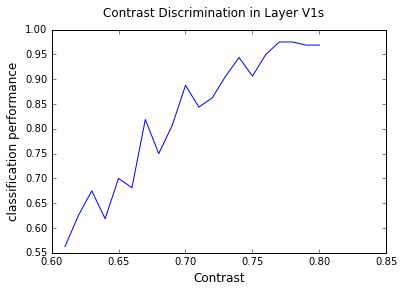

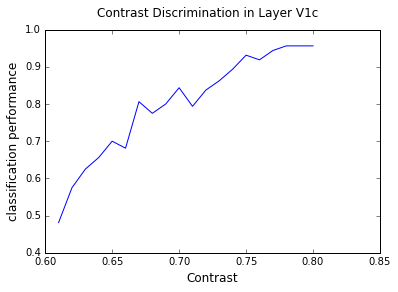

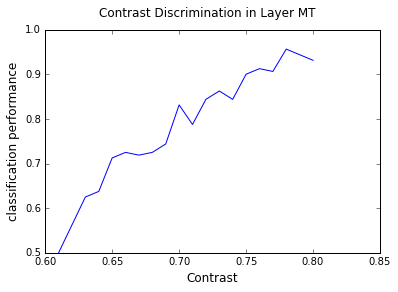

In [71]:
fpath = "Data/Psychophysics/"
regression_types = ['Coherence','Contrast']
regression_layers = ['LGN','V1s','V1c','MT']
afc_range = {}
afc_range['Coherence'] = np.arange(0.24,1.04,0.04)
afc_range['Contrast'] = np.arange(0.61,.80,0.01)

for j in range(len(regression_types)):
    reg_type = regression_types[j]
    for i in range(len(regression_layers)):
        reg_layer = regression_layers[i]
        fig = plt.figure()
        plt.plot(afc_range[reg_type],cv_scores[:,j,i])
        fig.suptitle(reg_type + ' Discrimination in Layer ' + reg_layer, fontsize=12)
        plt.xlabel(reg_type, fontsize=12)
        plt.ylabel('classification performance', fontsize=12)
        fig.savefig(fpath+'psychfig' +regression_types[j]+regression_layers[i]+ '.pdf', bbox_inches='tight')
        


In [83]:
fpath = "Data/PsychoRawData2/"
regression_types = ['Coherence']
regression_layers = ['MT']
afc_range = {}
afc_range['Coherence'] =  [0.25,0.30,0.35,0.40,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1.0]
afc_range['Contrast'] = np.arange(0.61,.80,0.01)

for j in range(len(regression_types)):
    reg_type = regression_types[j]
    for i in range(len(regression_layers)):
        reg_layer = regression_layers[i]
        reg_data = np.zeros((2,len(afc_range[reg_type])))
        reg_data[0,:] = afc_range[reg_type]
        reg_data[1,:] = cv_scores[:,j,i]
        np.savetxt(fpath+'psychdata' +regression_types[j]+regression_layers[i]+ '.txt',reg_data)
        


In [80]:
from assets.vis_utils import *
from assets.regressions import *
from assets.gen_motion import gen_dataset
#Linear Regressions
#Speed, as an example
regression_types = ['coherence']
all_types = ['speed','coherence','dots','contrast','Snoise']
regression_layers = ['MT']

afc_range = {}
afc_range['coherence'] = [0.25,0.30,0.35,0.40,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1.0]

train_scores = np.zeros((len(afc_range['coherence']),len(regression_types),len(regression_layers)))
cv_scores = np.zeros((len(afc_range['coherence']),len(regression_types),len(regression_layers)))


vary_params = {}
vary_params['speed'] = np.arange(0,5,0.5)
vary_params['coherence'] = np.arange(0,1,0.1)
vary_params['dots'] = np.arange(5,35,5)
vary_params['contrast'] = np.arange(0,1,0.1)
vary_params['Snoise'] = np.arange(0,100,10)

default_params = {}
default_params['speed'] = [3]
default_params['coherence'] = [.2]
default_params['dots'] = [25]
default_params['contrast'] = [0.6]
default_params['Snoise'] = [4]

regression_style = {}
regression_style['speed'] = 'logistic'
regression_style['coherence'] = 'logistic'
regression_style['dots'] = 'logistic'
regression_style['contrast'] = 'logistic'
regression_style['Snoise'] = 'logistic'

regression_index = {}
regression_index['speed'] = 1
regression_index['coherence'] = 3
regression_index['dots'] = 4
regression_index['contrast'] = 5
regression_index['Snoise'] = 6

for j in range(len(regression_types)):
    reg_type = regression_types[j]
    for k in range(len(afc_range[reg_type])):
        second_val = afc_range[reg_type][k]
        params = {}
        for label in all_types:
            if(reg_type == label):
                params[label] = [default_params[label][0],second_val]
            else:
                params[label] = default_params[label]
        X_train,Y_train,X_val,Y_val,X_test,Y_test = gen_dataset((16,64,64),100,None,['translate'],params['speed'],angles,params['coherence'],params['dots'],[0],dot_radius=2,contrast=params['contrast'],Snoise=params['Snoise'],retina=0)

        for i in range(len(regression_layers)):
            regression_layer = regression_layers[i]
            Z_train, Z_val, Z_test = obtain_output(best_model,regression_layer,X_train,X_val,X_test)

            #[type,speed,angle,coherence,num dots,contrast,noise]
            reg_style = regression_style[reg_type]
            reg_index = regression_index[reg_type]
            frames_only = False
            average_spatial = False

            y_train = Y_train[:,reg_index]
            y_val = Y_test[:,reg_index]
            y_test = Y_test[:,reg_index]
            if(frames_only):
                Z_train = np.swapaxes(Z_train,1,2) #swap kernels and time
                Z_val = np.swapaxes(Z_val,1,2) #swap kernels and time
                Z_test = np.swapaxes(Z_test,1,2) #swap kernels and time
                if(average_spatial):
                    Z_train = np.mean(Z_train,axis = (3,4))
                    Z_val = np.mean(Z_val,axis = (3,4))
                    Z_test = np.mean(Z_test,axis = (3,4))
                    Z_train = np.reshape(Z_train,(Z_train.shape[0]*Z_train.shape[1],Z_train.shape[2]))
                    Z_val = np.reshape(Z_val,(Z_val.shape[0]*Z_val.shape[1],Z_val.shape[2]))
                    Z_test = np.reshape(Z_test,(Z_test.shape[0]*Z_test.shape[1],Z_test.shape[2]))
                else:
                    Z_train = np.reshape(Z_train,(Z_train.shape[0]*Z_train.shape[1],Z_train.shape[2]*Z_train.shape[3]*Z_train.shape[4]))
                    Z_val = np.reshape(Z_val,(Z_val.shape[0]*Z_val.shape[1],Z_val.shape[2]*Z_val.shape[3]*Z_val.shape[4]))
                    Z_test = np.reshape(Z_test,(Z_test.shape[0]*Z_test.shape[1],Z_test.shape[2]*Z_test.shape[3]*Z_test.shape[4]))
                y_train = np.repeat(y_train,16)
                y_val = np.repeat(y_val,16)
                y_test = np.repeat(y_test,16)
            else:
                if(average_spatial):
                    Z_train = np.mean(Z_train,axis = (3,4))
                    Z_val = np.mean(Z_val,axis = (3,4))
                    Z_test = np.mean(Z_test,axis = (3,4))
                    Z_train = np.reshape(Z_train,(Z_train.shape[0],Z_train.shape[1]*Z_train.shape[2]))
                    Z_val = np.reshape(Z_val,(Z_val.shape[0],Z_val.shape[1]*Z_val.shape[2]))
                    Z_test = np.reshape(Z_test,(Z_test.shape[0],Z_test.shape[1]*Z_test.shape[2]))
                else:
                    Z_train = np.reshape(Z_train,(Z_train.shape[0],Z_train.shape[1]*Z_train.shape[2]*Z_train.shape[3]*Z_train.shape[4]))
                    Z_val = np.reshape(Z_val,(Z_val.shape[0],Z_val.shape[1]*Z_val.shape[2]*Z_val.shape[3]*Z_val.shape[4]))
                    Z_test = np.reshape(Z_test,(Z_test.shape[0],Z_test.shape[1]*Z_test.shape[2]*Z_test.shape[3]*Z_test.shape[4]))
            proportion_train = 1
            Z_train = Z_train[0:len(Z_train)*proportion_train]
            y_train = y_train[0:len(y_train)*proportion_train]

            if(reg_style == 'logistic'):
                min_val = np.min(y_train)
                max_val = np.max(y_train)
                y_train = (y_train - min_val)/(max_val - min_val)
                y_val = (y_val - min_val)/(max_val - min_val)
                y_test = (y_test - min_val)/(max_val - min_val)
            best_model_reg,cv_score,train_score = regression(Z_train,Z_val,Z_test,y_train,y_val,y_test,model_type=reg_style)
            print regression_layer
            print cv_score
            print train_score
            train_scores[k,j,i] = train_score
            cv_scores[k,j,i] = cv_score

Running layer:  MT
160/160 [==============================] - 1s     
MT
0.4625
1.0
Running layer:  MT
160/160 [==============================] - 2s     
MT
0.5375
1.0
Running layer:  MT
160/160 [==============================] - 1s     
MT
0.50625
1.0
Running layer:  MT
160/160 [==============================] - 2s     
MT
0.5625
1.0
Running layer:  MT
160/160 [==============================] - 1s     
MT
0.6
1.0
Running layer:  MT
160/160 [==============================] - 2s     
MT
0.63125
0.83375
Running layer:  MT
160/160 [==============================] - 1s     
MT
0.66875
1.0
Running layer:  MT
160/160 [==============================] - 2s     
MT
0.65
0.82125
Running layer:  MT
160/160 [==============================] - 2s     
MT
0.63125
1.0
Running layer:  MT
160/160 [==============================] - 2s     
MT
0.70625
1.0
Running layer:  MT
160/160 [==============================] - 1s     
MT
0.74375
1.0
Running layer:  MT
160/160 [==============================] - 2s   